In [139]:
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import balanced_accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from xgboost import XGBClassifier
import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import joblib

train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')

# columnsToDrop = ['MentHlth','Education','Income','AnyHealthcare','CholCheck','HvyAlcoholConsump','NoDocbcCost']
# 
# train_data = train_data.drop(columns=columnsToDrop)
# test_data = test_data.drop(columns=columnsToDrop)

categorical_cols = [
    # 'Age',
    'Sex',
    'Income',
    'Education'
] # here we will use OneHot (convert to numeric data)
numerical_cols = [
    'BMI',
    'PhysHlth',
    # 'GenHlth',
    'MentHlth'
] # here we will use scaling to give a better representation
# the rest of the columns are binary

# #Feature Engineering
# BMI_PhysActivity
train_data['GenHlth_Age'] = train_data['GenHlth'] * train_data['Age']
test_data['GenHlth_Age'] = test_data['GenHlth'] * test_data['Age']

train_data['PhysHlth_BMI'] = train_data['PhysHlth'] * train_data['BMI']
test_data['PhysHlth_BMI'] = test_data['PhysHlth'] * test_data['BMI']

train_data['PhysHlth_GenHlth_Age'] = train_data['PhysHlth'] * train_data['GenHlth_Age']
test_data['PhysHlth_GenHlth_Age'] = test_data['PhysHlth'] * test_data['GenHlth_Age']

train_data['BMI_GenHlth_Age'] = train_data['BMI'] * train_data['GenHlth_Age']
test_data['BMI_GenHlth_Age'] = test_data['BMI'] * test_data['GenHlth_Age']

for e in ['GenHlth_Age', 'PhysHlth_BMI', 'PhysHlth_GenHlth_Age', 'BMI_GenHlth_Age']:
    numerical_cols.append(e)

columnsToDrop = ['GenHlth','Age']

train_data = train_data.drop(columns=columnsToDrop)
test_data = test_data.drop(columns=columnsToDrop)

# Binning BMI into categories
bins = [0, 18.5, 25, 30, np.inf]
labels = ['Underweight', 'Normal', 'Overweight', 'Obese']
train_data['BMI_binned'] = pd.cut(train_data['BMI'], bins=bins, labels=labels)
test_data['BMI_binned'] = pd.cut(test_data['BMI'], bins=bins, labels=labels)

# You'll need to add 'BMI_binned' to your categorical columns list for OneHotEncoding
categorical_cols.append('BMI_binned')
 
X = train_data.drop(columns=['Target'])  # Drop target column
y = train_data['Target']  # Target column

# X = X.head(10000)
# y = y.head(10000)

X_apply = test_data

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=27)

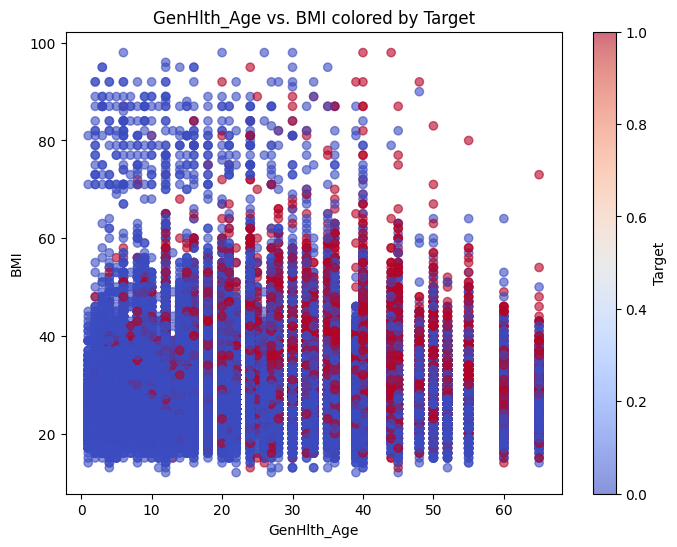

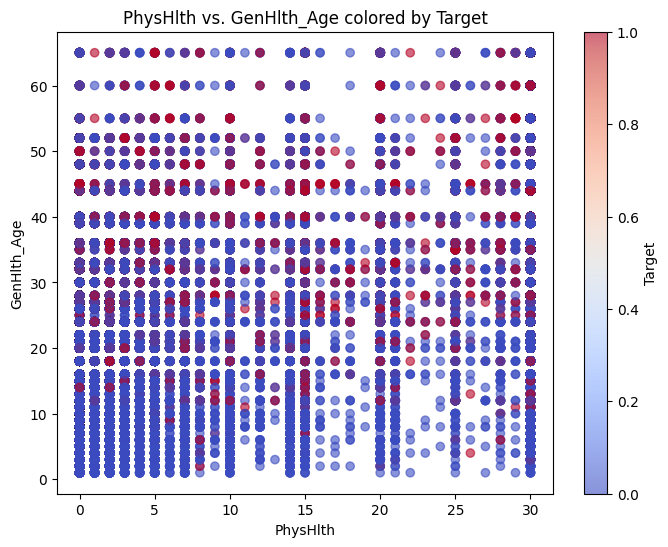

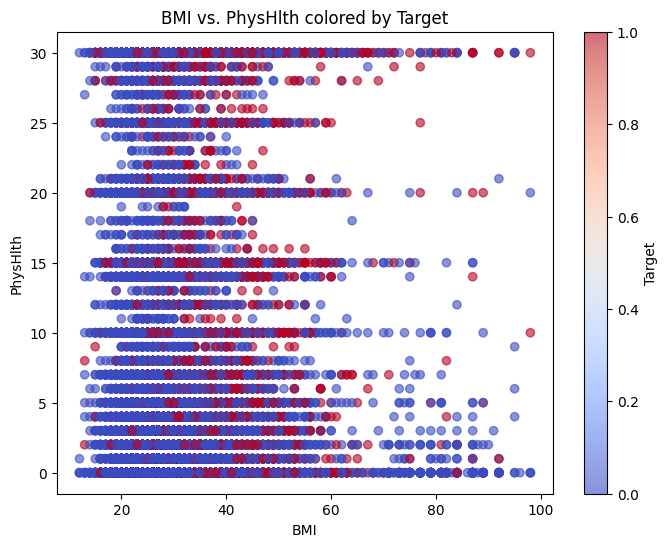

In [87]:


# Define the scatter plot function
def scatter_plot(df, x_col, y_col, color_col, title):
    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(df[x_col], df[y_col], c=df[color_col], cmap='coolwarm', alpha=0.6)
    plt.colorbar(scatter, label=color_col)
    plt.title(title)
    plt.xlabel(x_col)
    plt.ylabel(y_col)
    plt.show()

# Create scatter plots for selected features
scatter_plot(train_data, 'GenHlth_Age', 'BMI', 'Target', 'GenHlth_Age vs. BMI colored by Target')
scatter_plot(train_data, 'PhysHlth', 'GenHlth_Age', 'Target', 'PhysHlth vs. GenHlth_Age colored by Target')
scatter_plot(train_data, 'BMI', 'PhysHlth', 'Target', 'BMI vs. PhysHlth colored by Target')

In [137]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(), categorical_cols)
    ])

model = ImbPipeline([
    ('preprocessor', preprocessor),
    # ('smote', SMOTE(random_state=27)),
    ('classifier', RandomForestClassifier(
        random_state=27, 
        class_weight='balanced', 
        criterion='entropy', 
        n_estimators=100,
        max_depth=14,
        min_samples_split=4,
        min_samples_leaf=6,
    )),
    # ('classifier', lgb.LGBMClassifier(random_state=27)),
    # ('classifier', XGBClassifier(
    #     scale_pos_weight=len(y_train[y_train == 0]) / len(y_train[y_train == 1]), 
    #     random_state=27,
    #     max_depth=10,
    #     colsample_bytree=0.8,
    #     gamma=0.1,
    #     learning_rate=0.1,
    #     min_child_weight=3,
    #     n_estimators=100,
    #     reg_alpha=0,
    #     reg_lambda=100,
    #     subsample=0.6,
    # ))
])

# param_grid = {
#     'classifier__n_estimators': [50, 100, 200],
#     'classifier__max_depth': [None, 10, 20, 30],
#     'classifier__min_samples_split': [2, 5, 10],
#     'classifier__min_samples_leaf': [1, 2, 4],
# }

# param_grid = {
#     'classifier__n_estimators': [100, 200, 500],
#     'classifier__max_depth': [3, 6, 10],
#     'classifier__learning_rate': [0.01, 0.05, 0.1],
#     'classifier__subsample': [0.6, 0.8, 1.0],
#     'classifier__colsample_bytree': [0.6, 0.8, 1.0],
#     'classifier__min_child_weight': [1, 3, 5],
#     'classifier__gamma': [0, 0.1, 0.3],
#     'classifier__reg_alpha': [0, 0.01, 0.1],
#     'classifier__reg_lambda': [1, 10, 100]
# }

# param_grid = {
#     'classifier__learning_rate': [0.01, 0.1],
#     'classifier__n_estimators': [100, 200],
#     'classifier__max_depth': [10, 20, 30],
#     'classifier__subsample': [0.8, 1.0],
#     'classifier__colsample_bytree': [0.8, 1.0]
# }
# 
# grid_search = GridSearchCV(model, param_grid, cv=3, scoring='balanced_accuracy', verbose=2)
# grid_search.fit(X_train, y_train)
# 
# print("Best parameters found: ", grid_search.best_params_)
# print("Best balanced accuracy score: ", grid_search.best_score_)

model.fit(X_train,y_train)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['BMI', 'PhysHlth', 'GenHlth',
                                                   'MentHlth', 'GenHlth_Age',
                                                   'PhysHlth_BMI',
                                                   'PhysHlth_GenHlth_Age',
                                                   'BMI_GenHlth_Age']),
                                                 ('cat', OneHotEncoder(),
                                                  ['Age', 'Sex', 'Income',
                                                   'Education',
                                                   'BMI_binned'])])),
                ('classifier',
                 RandomForestClassifier(class_weight='balanced',
                                        criterion='entropy', max_depth=14,
                                        min_samples_leaf=6, min_samples_split=4,
                                        random_state=27))])

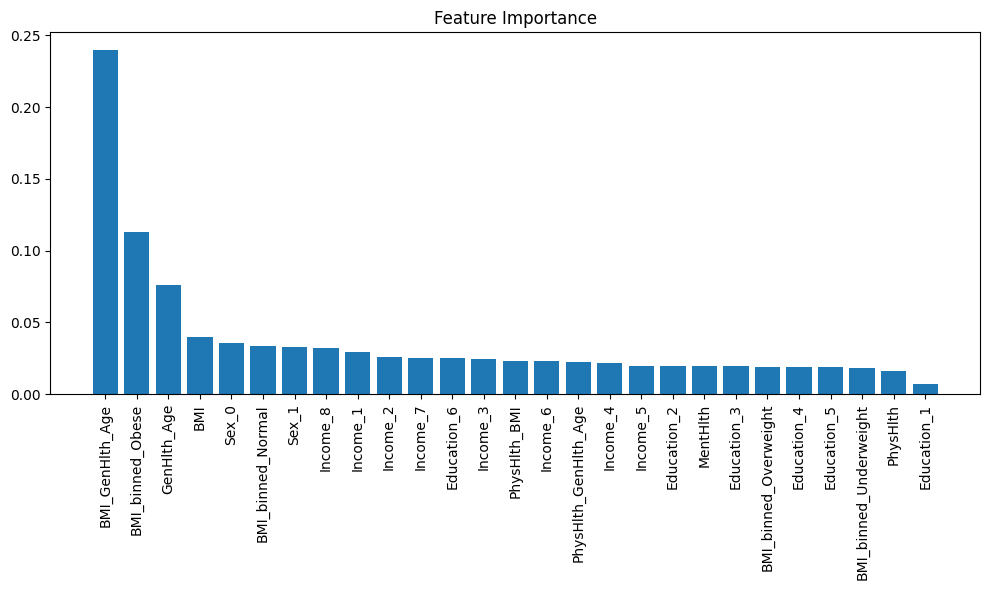

In [131]:
importances = model.named_steps['classifier'].feature_importances_
feature_names = numerical_cols + list(model.named_steps['preprocessor'].transformers_[1][1].get_feature_names_out())
sorted_indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10, 6))
plt.title('Feature Importance')
plt.bar(range(len(sorted_indices)), importances[sorted_indices], align='center')
plt.xticks(range(len(sorted_indices)), np.array(feature_names)[sorted_indices], rotation=90)
plt.tight_layout()
plt.show()

In [138]:

# 
# joblib.dump(model, 'diabeticPredictor-XGB.joblib')
# model = joblib.load('diabeticPredictor-XGB.joblib')

predictions = model.predict(X_test)
score = balanced_accuracy_score(y_test, predictions)

print(score)
# print(classification_report(y_test, predictions))

threshold = 0.462

y_pred_proba = model.predict_proba(X_apply)[:, 1]
predictions = (y_pred_proba > threshold).astype(int)

# # Print classification report (for your validation data)
X_train_part, X_val, y_train_part, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Evaluate the model with the validation set
y_pred_val_proba = model.predict_proba(X_val)[:, 1]
val_predictions = (y_pred_val_proba > threshold).astype(int)
val_score = balanced_accuracy_score(y_val, val_predictions)

# submission_df = pd.DataFrame({
#     'Id': X_apply['Id'],  # Assuming 'Id' is the name of the ID column in X_apply
#     'Target': predictions
# })
# 
# # Save the predictions to a CSV file
# submission_df.to_csv('submission-xgb_17-09-24.csv', index=False)

# Output evaluation metrics for validation data
print(f"Balanced Accuracy Score on Validation: {val_score}")
print(classification_report(y_val, val_predictions))

0.7268219705102055
Balanced Accuracy Score on Validation: 0.7644307335215138
              precision    recall  f1-score   support

           0       0.96      0.70      0.81     24435
           1       0.31      0.83      0.45      3977

    accuracy                           0.72     28412
   macro avg       0.64      0.76      0.63     28412
weighted avg       0.87      0.72      0.76     28412

